#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib

* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all', reversed=False):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    elif reversed:
        fi_df = fi_temp.iloc[-topn:]
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        #plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
FOLDER_PATH = '/content/drive/MyDrive/에이블/미니프로젝트5차_3~5일차/Kaggle'

In [11]:
data = pd.read_csv(os.path.join(FOLDER_PATH,'train.csv'))

In [ ]:
# features = pd.read_csv(os.path.join(FOLDER_PATH,'features.csv'))

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [12]:
data.head()

,Unnamed: 0,timestamp,A_x,A_y,A_z,B_x,B_y,B_z,label
0,0,2019-01-12 00:45:54.450,-0.259130,-0.834869,-0.485499,0.196409,NaN,0.384934,8
1,1,2000-01-01 01:37:06.440,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2
2,2,2019-01-12 00:45:33.900,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8
3,3,2000-01-01 00:46:22.680,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11
4,4,2000-01-01 00:49:56.620,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  100000 non-null  int64  
 1   timestamp   100000 non-null  object 
 2   A_x         90000 non-null   float64
 3   A_y         90000 non-null   float64
 4   A_z         90000 non-null   float64
 5   B_x         90000 non-null   float64
 6   B_y         90000 non-null   float64
 7   B_z         90000 non-null   float64
 8   label       100000 non-null  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 6.9+ MB


In [14]:
data.describe()

,Unnamed: 0,A_x,A_y,A_z,B_x,B_y,B_z,label
count,100000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,100000.000000
mean,49999.500000,-0.876639,-0.110566,-0.013331,-0.780543,0.116559,0.167377,5.945630
std,28867.657797,0.464709,0.348463,0.361989,0.817925,0.593224,0.785482,3.333515
min,0.000000,-5.132823,-1.949310,-1.284750,-7.483251,-5.466767,-7.208220,1.000000
25%,24999.750000,-1.016718,-0.181035,-0.281950,-1.050645,-0.190546,-0.243964,3.000000
50%,49999.500000,-0.958268,-0.047425,-0.063756,-0.918144,0.023954,0.113276,7.000000
75%,74999.250000,-0.764307,0.060235,0.222074,-0.157112,0.319651,0.525970,9.000000
max,99999.000000,1.849398,2.413866,2.584467,5.372528,7.182237,6.766558,11.000000


In [15]:
# features.head()

In [16]:
# features.info()

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'label'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [21]:
target = 'label' # train데이터의 label

In [22]:
data[target].describe()

count    100000.000000
mean          5.945630
std           3.333515
min           1.000000
25%           3.000000
50%           7.000000
75%           9.000000
max          11.000000
Name: label, dtype: float64

In [23]:
data[target].value_counts(normalize=True)

2     0.12170
8     0.11497
1     0.11465
7     0.10594
10    0.09579
9     0.09282
11    0.09112
3     0.08305
4     0.07208
5     0.05411
6     0.05377
Name: label, dtype: float64

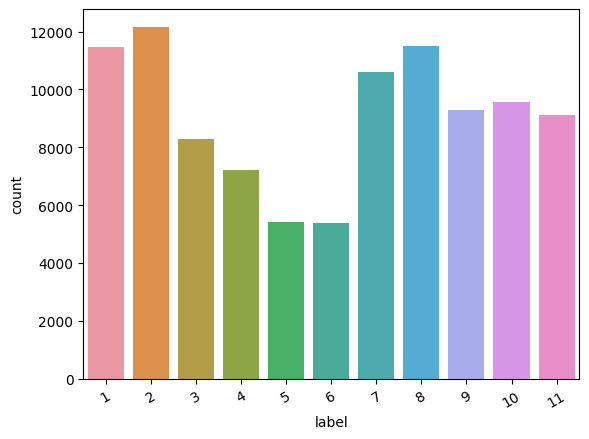

In [24]:
sns.countplot(x=target, data=data)
plt.xticks(rotation=30)
plt.show()

### (3) 센서 그룹 데이터: features -> 제외

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [ ]:
features['sensor'].value_counts()

fBodyGyro               79
fBodyAcc                79
fBodyAccJerk            79
tBodyAcc                40
tBodyAccJerk            40
tBodyGyro               40
tBodyGyroJerk           40
tGravityAcc             40
fBodyBodyGyroJerkMag    13
fBodyBodyGyroMag        13
fBodyBodyAccJerkMag     13
fBodyAccMag             13
tBodyGyroJerkMag        13
tBodyGyroMag            13
tBodyAccJerkMag         13
tGravityAccMag          13
tBodyAccMag             13
angle                    7
Name: sensor, dtype: int64

In [ ]:
features['agg'].value_counts()

bandsEnergy()        126
arCoeff()             60
mean()                33
mad()                 33
max()                 33
min()                 33
energy()              33
iqr()                 33
entropy()             33
std()                 33
sma()                 17
correlation()         15
meanFreq()            13
kurtosis()            13
skewness()            13
maxInds               13
arCoeff()3             5
arCoeff()4             5
arCoeff()2             5
arCoeff()1             5
tBodyAccMean           1
tBodyAccJerkMean       1
tBodyGyroMean          1
tBodyGyroJerkMean      1
X                      1
Y                      1
Z                      1
Name: agg, dtype: int64

In [ ]:
features['axis'].value_counts()

X              76
Y              76
Z              76
gravityMean     6
X,2             5
               ..
25,32.1         2
17,24.1         2
1,8.1           2
9,16.1          2
gravity         1
Name: axis, Length: 62, dtype: int64

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [25]:
x = data.drop(target, axis = 1)
y = data[target]
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(80000, 8) (20000, 8) (80000,) (20000,)


In [28]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier()
RF_model.fit(x_train, y_train)
RF_model.score(x_valid, y_valid)

ValueError: ignored

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.037048
1,tGravityAcc-max()-X,0.032245
2,tGravityAcc-mean()-Y,0.030593
3,tGravityAcc-max()-Y,0.028234
4,tGravityAcc-mean()-X,0.026892
5,"angle(X,gravityMean)",0.026631
6,tGravityAcc-min()-Y,0.023851
7,tGravityAcc-min()-X,0.020440
8,"angle(Y,gravityMean)",0.020064
9,"fBodyAccJerk-bandsEnergy()-1,16",0.015718


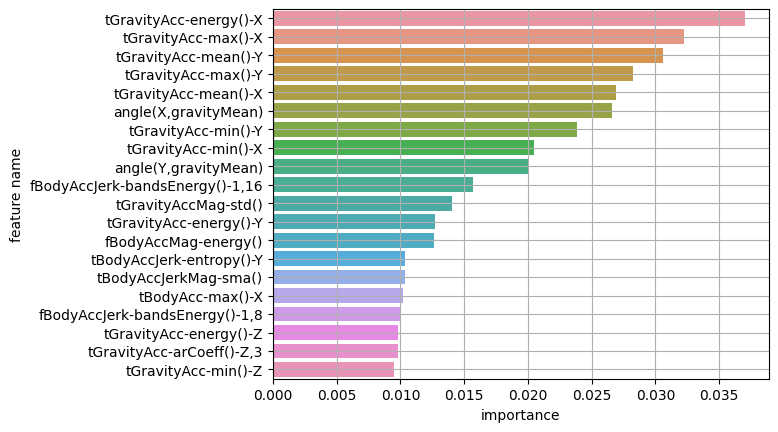

In [ ]:
plot_feature_importance(RF_model.feature_importances_, x.columns, topn=20)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.037048
1,tGravityAcc-max()-X,0.032245
2,tGravityAcc-mean()-Y,0.030593
3,tGravityAcc-max()-Y,0.028234
4,tGravityAcc-mean()-X,0.026892
5,"angle(X,gravityMean)",0.026631
6,tGravityAcc-min()-Y,0.023851
7,tGravityAcc-min()-X,0.020440
8,"angle(Y,gravityMean)",0.020064
9,"fBodyAccJerk-bandsEnergy()-1,16",0.015718


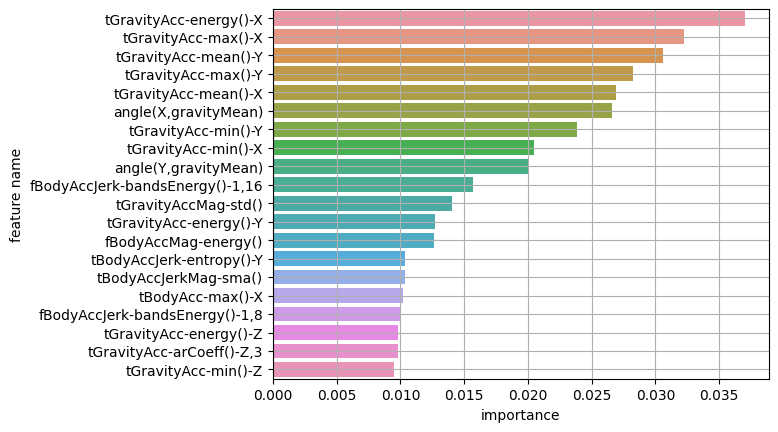

In [ ]:
n, m = 20, 20
plot_feature_importance(RF_model.feature_importances_, x.columns, topn=n)

,feature_name,feature_importance
542,"tBodyGyro-arCoeff()-X,2",0.000127
543,tBodyGyroJerkMag-min(),0.000125
544,fBodyBodyGyroJerkMag-iqr(),0.000125
545,"fBodyAccJerk-bandsEnergy()-41,48",0.000123
546,"fBodyAcc-bandsEnergy()-49,56.1",0.000123
547,"tBodyGyroJerk-arCoeff()-Y,2",0.000116
548,tBodyAccJerkMag-arCoeff()3,0.000114
549,"fBodyAcc-bandsEnergy()-57,64.2",0.000110
550,"angle(tBodyAccMean,gravity)",0.000105
551,"fBodyAccJerk-bandsEnergy()-33,48.1",0.000105


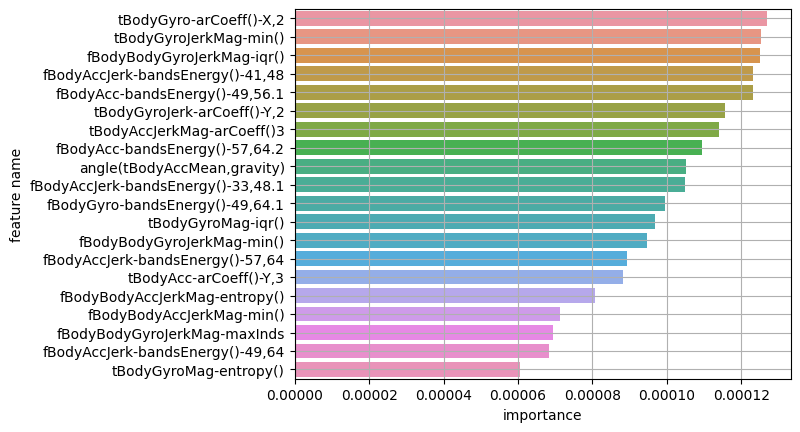

In [ ]:
plot_feature_importance(RF_model.feature_importances_, x.columns, topn=m, reversed=True)

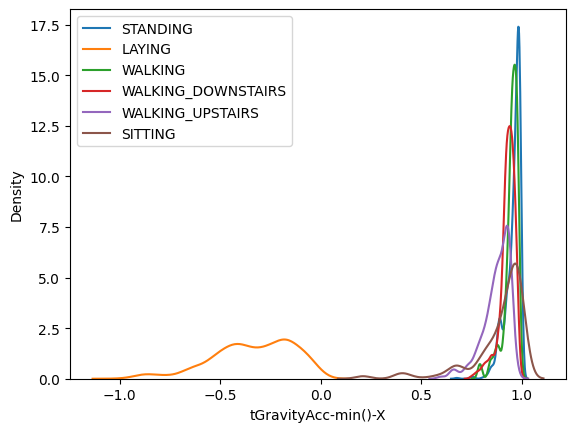

In [ ]:
for category in data[target].unique():
    category_data = data[data[target] == category]
    sns.kdeplot(category_data['tGravityAcc-min()-X'], label = category)
plt.legend()
plt.show()

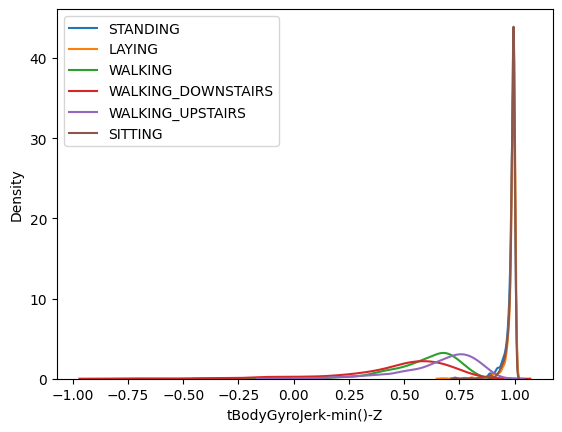

In [ ]:
for category in data[target].unique():
    category_data = data[data[target] == category]
    sns.kdeplot(category_data['tBodyGyroJerk-min()-Z'], label = category)
plt.legend()
plt.show()

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.


In [ ]:
importances = pd.DataFrame({
    'feature_name': x.columns,
    'importance': RF_model.feature_importances_
})
fi = pd.merge(features, importances, on='feature_name')
fi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sensor        561 non-null    object 
 1   agg           561 non-null    object 
 2   axis          436 non-null    object 
 3   feature_name  561 non-null    object 
 4   importance    561 non-null    float64
dtypes: float64(1), object(4)
memory usage: 26.3+ KB


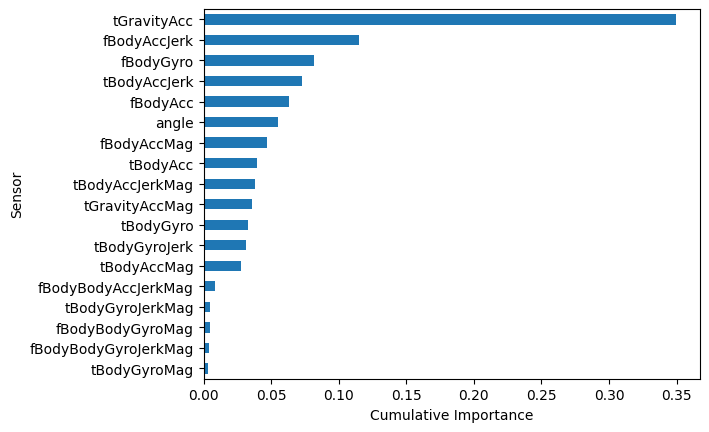

In [ ]:
sensor_importance = fi.groupby('sensor')['importance'].sum().sort_values()
sensor_importance.plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor")
plt.show()

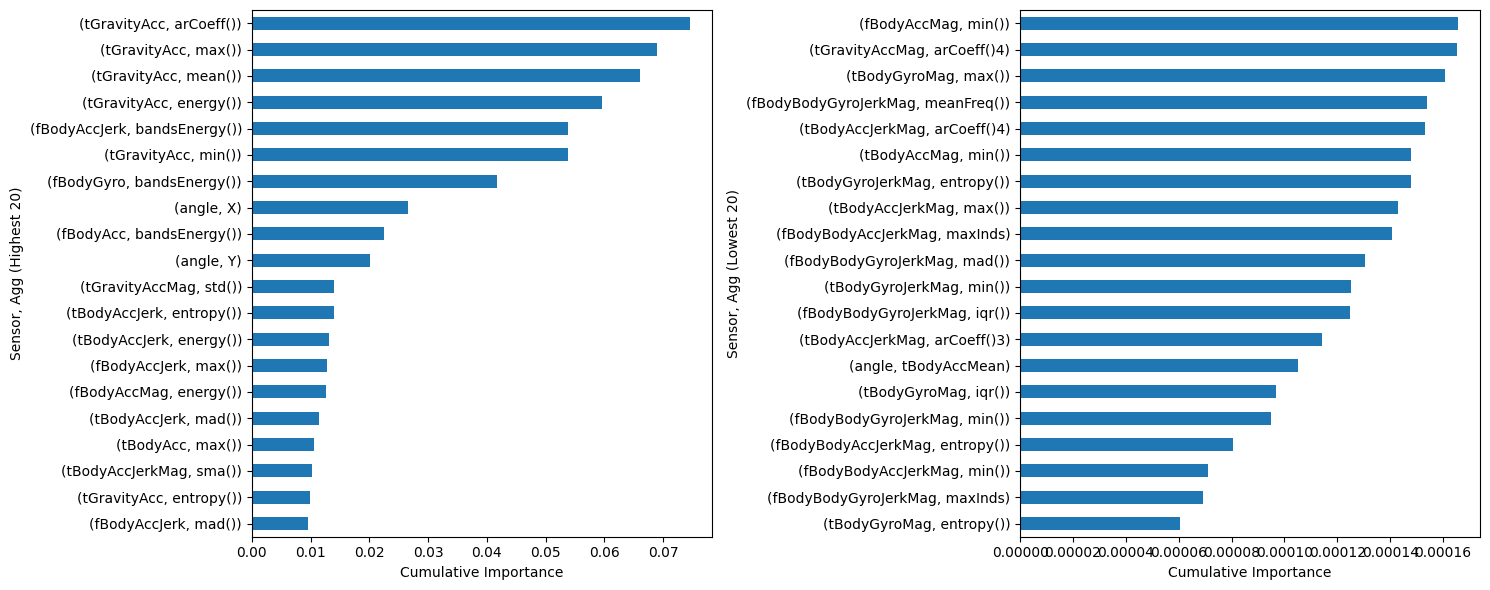

In [ ]:
sensor_agg_importance = fi.groupby(['sensor', 'agg'])['importance'].sum().sort_values()

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sensor_agg_importance.tail(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Highest 20)")

plt.subplot(1,2,2)
sensor_agg_importance.head(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Lowest 20)")
plt.tight_layout()
plt.show()

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [ ]:
def convert_activity_to_dynamic(activity):
    if activity in ['STANDING', 'SITTING', 'LAYING']:
        return 0
    elif activity in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']:
        return 1
y = data['Activity'].apply(convert_activity_to_dynamic)
y.value_counts()

0    3234
1    2647
Name: Activity, dtype: int64

#### 2) 기본모델 생성

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(4704, 562) (1177, 562) (4704,) (1177,)


In [ ]:
RF_model2 = RandomForestClassifier(random_state=42)
RF_model2.fit(x_train, y_train)
print(RF_model2.score(x_valid, y_valid))

0.9991503823279524


#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,tBodyAccJerk-std()-X,0.050094
1,tBodyAccJerkMag-entropy(),0.049923
2,fBodyAccJerk-energy()-X,0.039994
3,fBodyAccJerk-std()-X,0.039957
4,"fBodyAcc-bandsEnergy()-9,16",0.039673


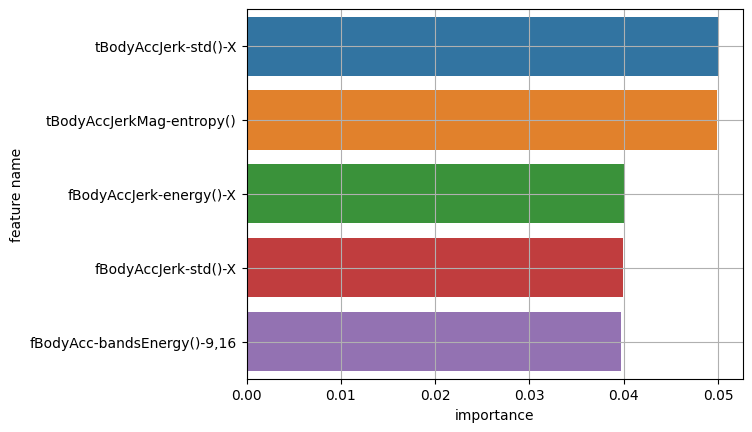

In [ ]:
plot_feature_importance(RF_model2.feature_importances_, x.columns, topn=5)

#### 4) feature 그룹별 분석

In [ ]:
importances2 = pd.DataFrame({
    'feature_name': x.columns,
    'importance': RF_model2.feature_importances_
})
fi2 = pd.merge(features, importances2, on='feature_name')
fi2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sensor        561 non-null    object 
 1   agg           561 non-null    object 
 2   axis          436 non-null    object 
 3   feature_name  561 non-null    object 
 4   importance    561 non-null    float64
dtypes: float64(1), object(4)
memory usage: 26.3+ KB


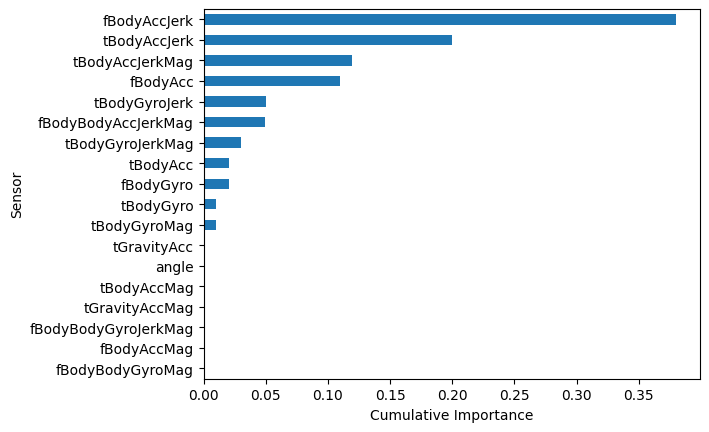

In [ ]:
sensor_importance2 = fi2.groupby('sensor')['importance'].sum().sort_values()
sensor_importance2.plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor")
plt.show()

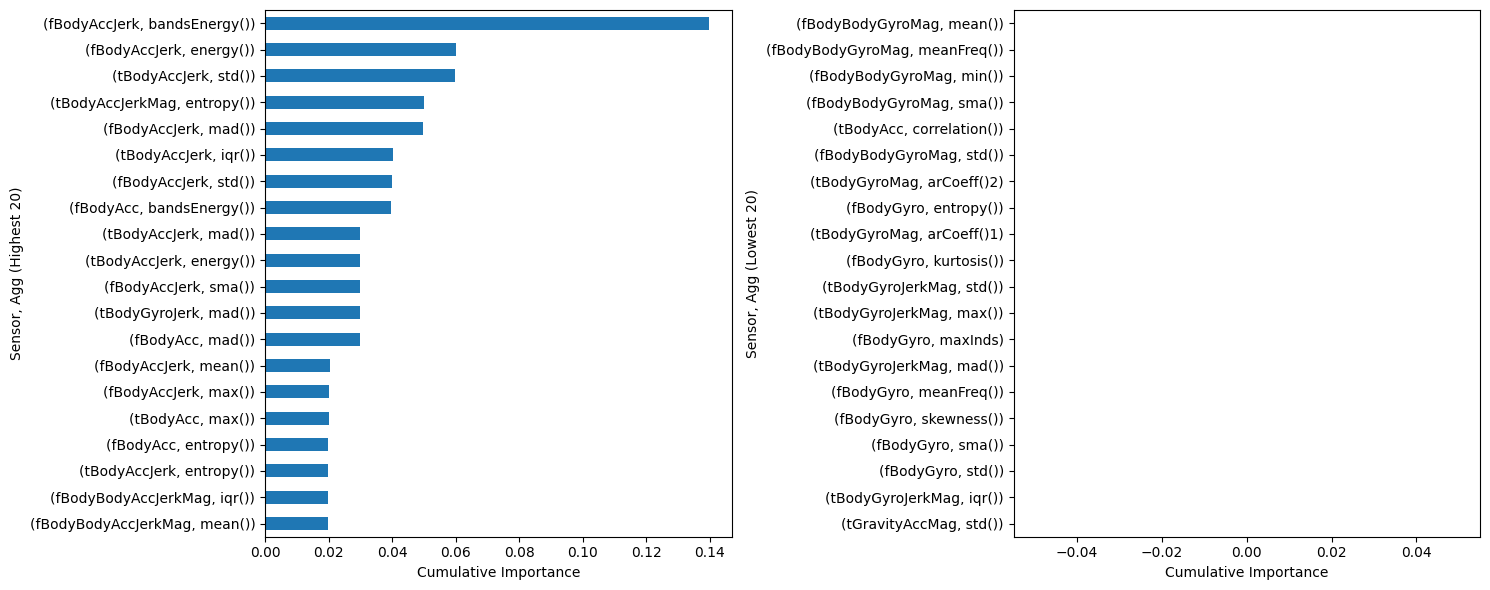

In [ ]:
sensor_agg_importance2 = fi2.groupby(['sensor', 'agg'])['importance'].sum().sort_values()

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sensor_agg_importance2.tail(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Highest 20)")

plt.subplot(1,2,2)
sensor_agg_importance2.head(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Lowest 20)")
plt.tight_layout()
plt.show()

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
def convert_activity_to_standing(activity):
    if activity == 'STANDING':
        return 1
    else:
        return 0
y = data['Activity'].apply(convert_activity_to_standing)
y.value_counts()

0    4794
1    1087
Name: Activity, dtype: int64

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(4704, 562) (1177, 562) (4704,) (1177,)


In [ ]:
RF_model3 = RandomForestClassifier(random_state=42)
RF_model3.fit(x_train, y_train)
print(RF_model3.score(x_valid, y_valid))

0.9864061172472387


,feature_name,feature_importance
0,tGravityAcc-min()-Y,0.062644
1,tGravityAcc-mean()-Y,0.055818
2,"angle(Y,gravityMean)",0.050844
3,tGravityAcc-max()-Y,0.046787
4,tGravityAcc-min()-Z,0.037753


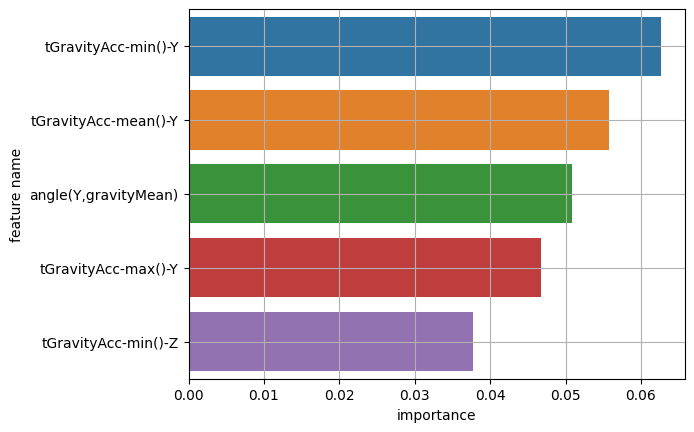

In [ ]:
plot_feature_importance(RF_model3.feature_importances_, x.columns, topn=5)

In [ ]:
importances3 = pd.DataFrame({
    'feature_name': x.columns,
    'importance': RF_model3.feature_importances_
})
fi3 = pd.merge(features, importances3, on='feature_name')
fi3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sensor        561 non-null    object 
 1   agg           561 non-null    object 
 2   axis          436 non-null    object 
 3   feature_name  561 non-null    object 
 4   importance    561 non-null    float64
dtypes: float64(1), object(4)
memory usage: 26.3+ KB


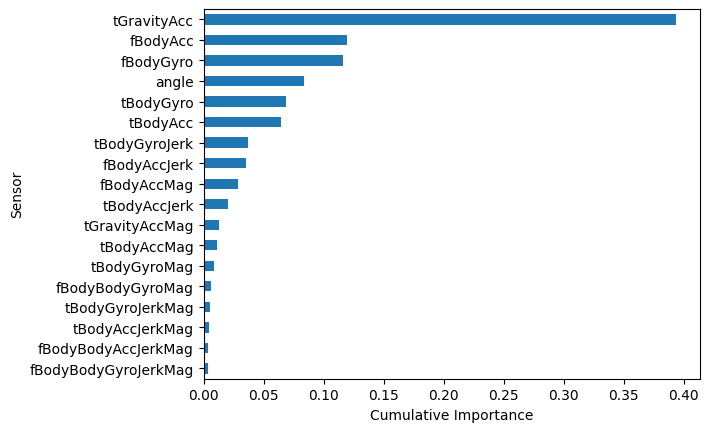

In [ ]:
sensor_importance3 = fi3.groupby('sensor')['importance'].sum().sort_values()
sensor_importance3.plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor")
plt.show()

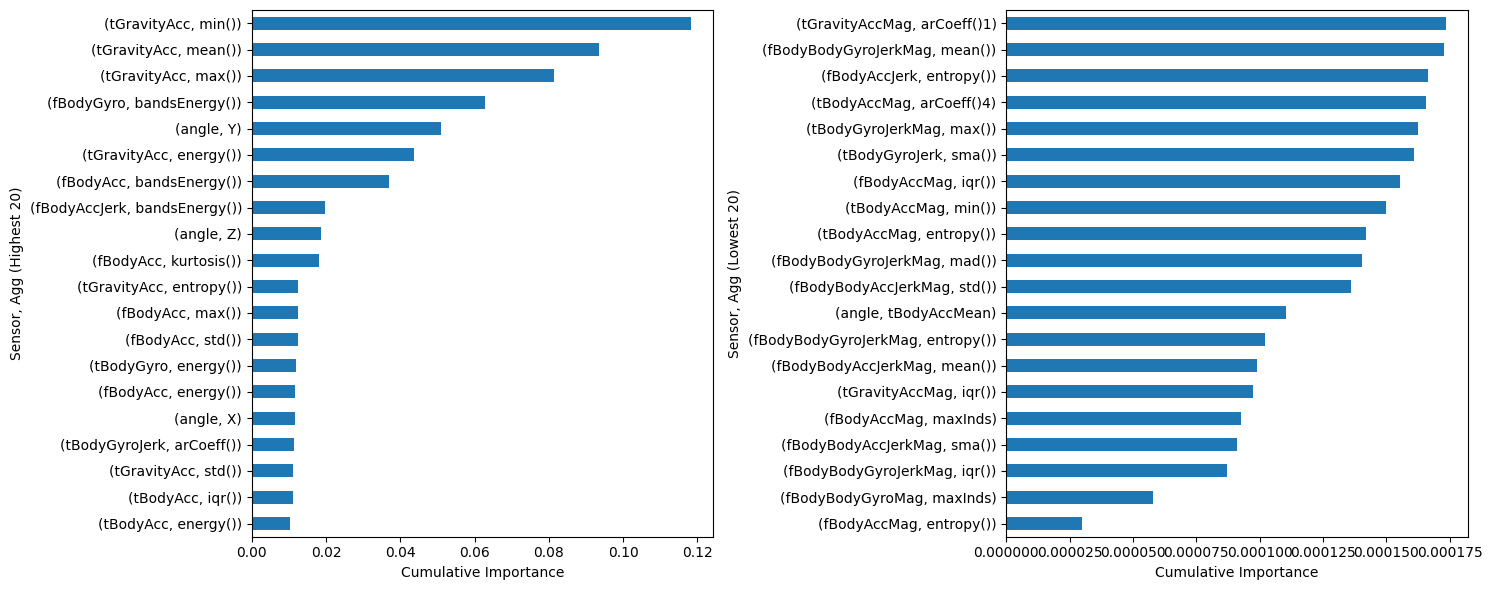

In [ ]:
sensor_agg_importance3 = fi3.groupby(['sensor', 'agg'])['importance'].sum().sort_values()
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sensor_agg_importance3.tail(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Highest 20)")

plt.subplot(1,2,2)
sensor_agg_importance3.head(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Lowest 20)")
plt.tight_layout()
plt.show()

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
def convert_activity_to_sitting(activity):
    if activity == 'SITTING':
        return 1
    else:
        return 0
y = data['Activity'].apply(convert_activity_to_sitting)
y.value_counts()

0    4849
1    1032
Name: Activity, dtype: int64

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(4704, 562) (1177, 562) (4704,) (1177,)


In [ ]:
RF_model4 = sk.ensemble.RandomForestClassifier(random_state=42)
RF_model4.fit(x_train, y_train)
print(RF_model4.score(x_valid, y_valid))

0.9804587935429057


,feature_name,feature_importance
0,tGravityAcc-mean()-Y,0.051500
1,tGravityAcc-min()-Y,0.039555
2,tGravityAcc-max()-Y,0.037522
3,"angle(Y,gravityMean)",0.033702
4,tGravityAcc-energy()-X,0.027140


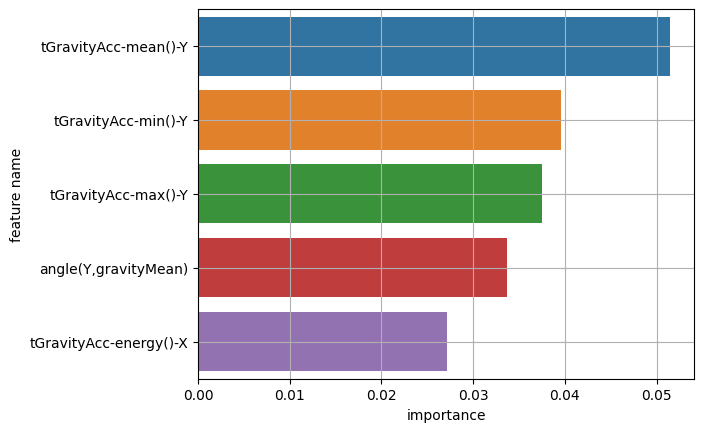

In [ ]:
plot_feature_importance(RF_model4.feature_importances_, x.columns, topn=5)

In [ ]:
importances4 = pd.DataFrame({
    'feature_name': x.columns,
    'importance': RF_model4.feature_importances_
})
fi4 = pd.merge(features, importances4, on='feature_name')
fi4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sensor        561 non-null    object 
 1   agg           561 non-null    object 
 2   axis          436 non-null    object 
 3   feature_name  561 non-null    object 
 4   importance    561 non-null    float64
dtypes: float64(1), object(4)
memory usage: 26.3+ KB


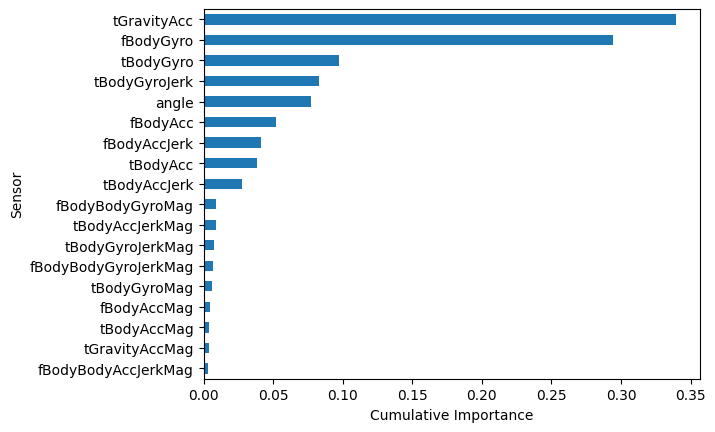

In [ ]:
sensor_importance4 = fi4.groupby('sensor')['importance'].sum().sort_values()
sensor_importance4.plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor")
plt.show()

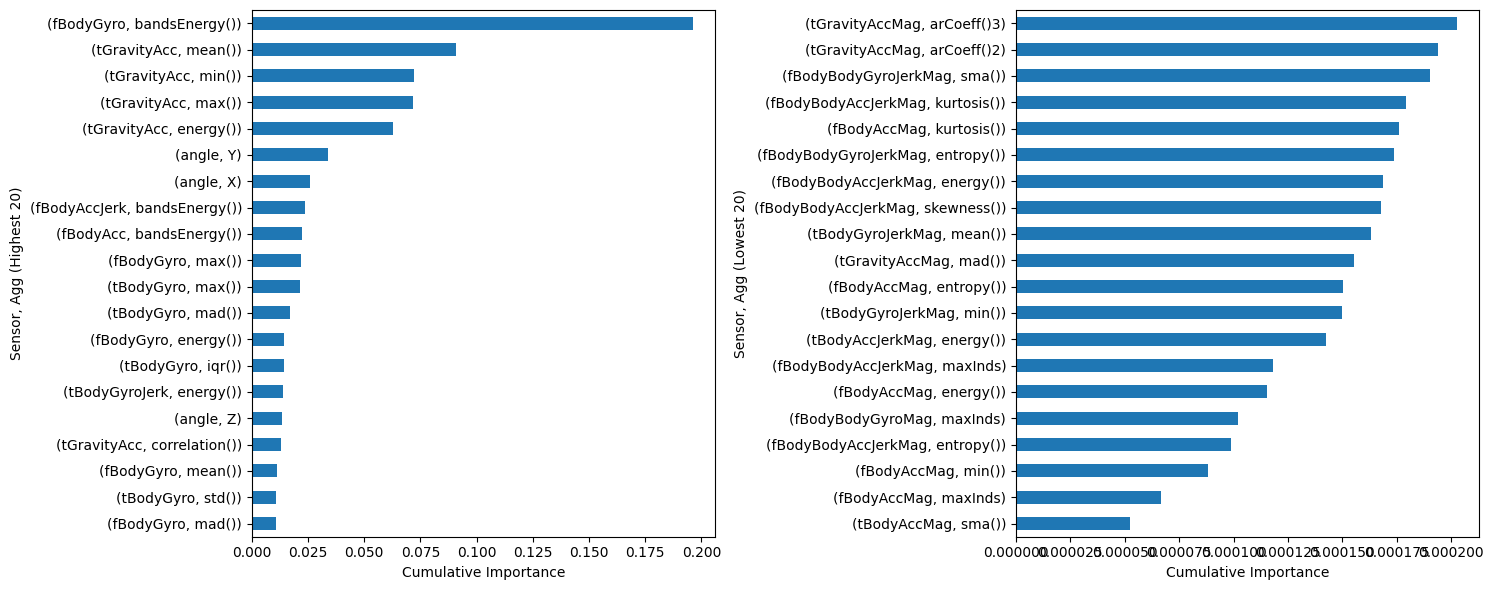

In [ ]:
sensor_agg_importance4 = fi4.groupby(['sensor', 'agg'])['importance'].sum().sort_values()
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sensor_agg_importance4.tail(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Highest 20)")

plt.subplot(1,2,2)
sensor_agg_importance4.head(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Lowest 20)")
plt.tight_layout()
plt.show()

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
def convert_activity_to_laying(activity):
    if activity == 'LAYING':
        return 1
    else:
        return 0
y = data['Activity'].apply(convert_activity_to_laying)
y.value_counts()

0    4766
1    1115
Name: Activity, dtype: int64

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(4704, 562) (1177, 562) (4704,) (1177,)


In [ ]:
RF_model5 = RandomForestClassifier(random_state=42)
RF_model5.fit(x_train, y_train)
print(RF_model5.score(x_valid, y_valid))

1.0


,feature_name,feature_importance
0,tGravityAcc-min()-X,0.125874
1,"angle(X,gravityMean)",0.092422
2,tGravityAcc-mean()-Y,0.080790
3,tGravityAcc-mean()-X,0.067502
4,tGravityAcc-mean()-Z,0.050722


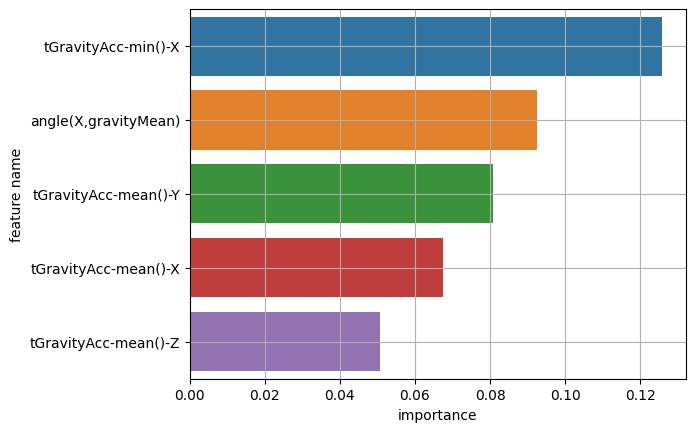

In [ ]:
plot_feature_importance(RF_model5.feature_importances_, x.columns, topn=5)

In [ ]:
importances5 = pd.DataFrame({
    'feature_name': x.columns,
    'importance': RF_model5.feature_importances_
})
fi5 = pd.merge(features, importances5, on='feature_name')
fi5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sensor        561 non-null    object 
 1   agg           561 non-null    object 
 2   axis          436 non-null    object 
 3   feature_name  561 non-null    object 
 4   importance    561 non-null    float64
dtypes: float64(1), object(4)
memory usage: 26.3+ KB


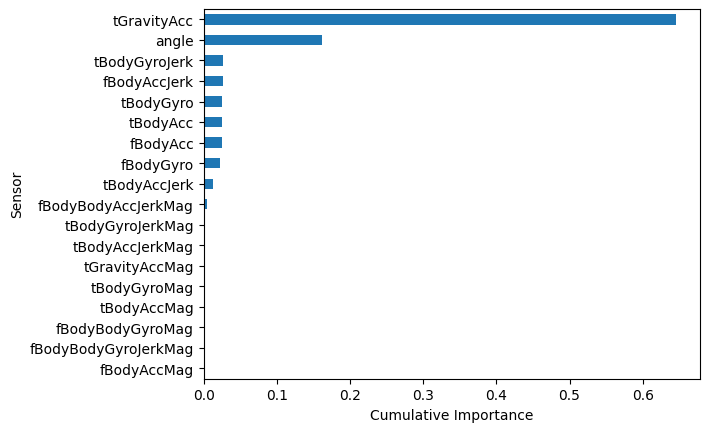

In [ ]:
sensor_importance5 = fi5.groupby('sensor')['importance'].sum().sort_values()
sensor_importance5.plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor")
plt.show()

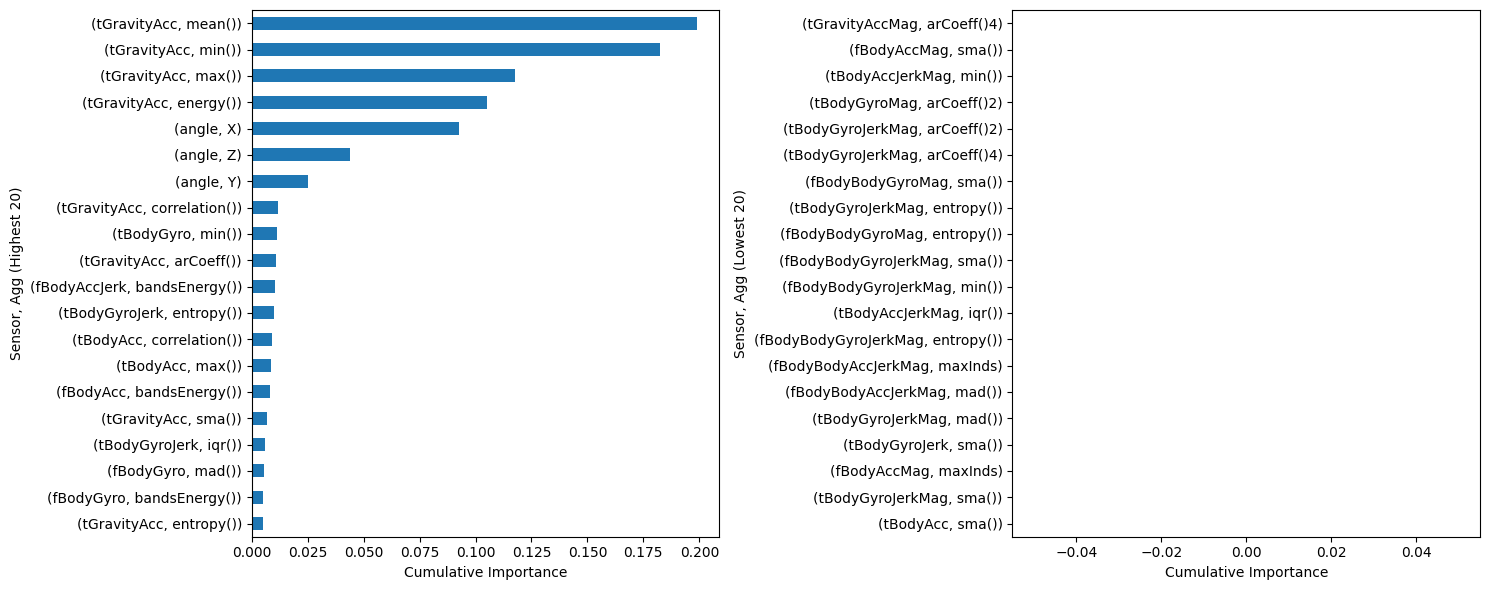

In [ ]:
sensor_agg_importance5 = fi5.groupby(['sensor', 'agg'])['importance'].sum().sort_values()
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sensor_agg_importance5.tail(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Highest 20)")

plt.subplot(1,2,2)
sensor_agg_importance5.head(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Lowest 20)")
plt.tight_layout()
plt.show()

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
def convert_activity_to_walking(activity):
    if activity == 'WALKING':
        return 1
    else:
        return 0
y = data['Activity'].apply(convert_activity_to_walking)
y.value_counts()

0    4883
1     998
Name: Activity, dtype: int64

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(4704, 562) (1177, 562) (4704,) (1177,)


In [ ]:
RF_model6 = sk.ensemble.RandomForestClassifier(random_state=42)
RF_model6.fit(x_train, y_train)
print(RF_model6.score(x_valid, y_valid))

0.994052676295667


,feature_name,feature_importance
0,"tGravityAcc-arCoeff()-X,2",0.025561
1,fBodyAccMag-std(),0.024764
2,fBodyAccMag-mad(),0.022929
3,tGravityAccMag-std(),0.022550
4,"tGravityAcc-arCoeff()-X,1",0.022398


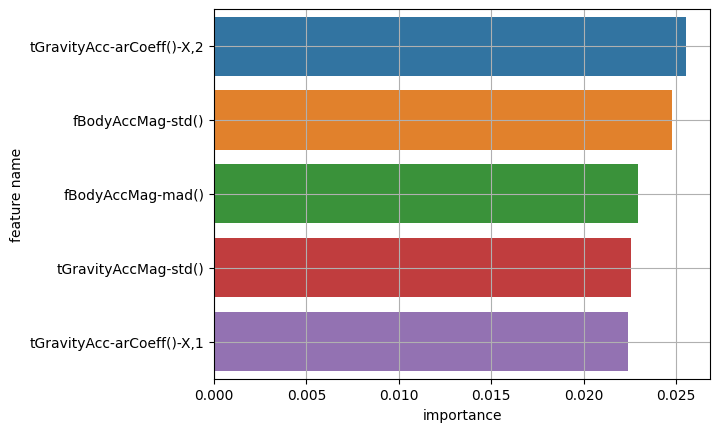

In [ ]:
plot_feature_importance(RF_model6.feature_importances_, x.columns, topn=5)

In [ ]:
importances6 = pd.DataFrame({
    'feature_name': x.columns,
    'importance': RF_model6.feature_importances_
})
fi6 = pd.merge(features, importances6, on='feature_name')
fi6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sensor        561 non-null    object 
 1   agg           561 non-null    object 
 2   axis          436 non-null    object 
 3   feature_name  561 non-null    object 
 4   importance    561 non-null    float64
dtypes: float64(1), object(4)
memory usage: 26.3+ KB


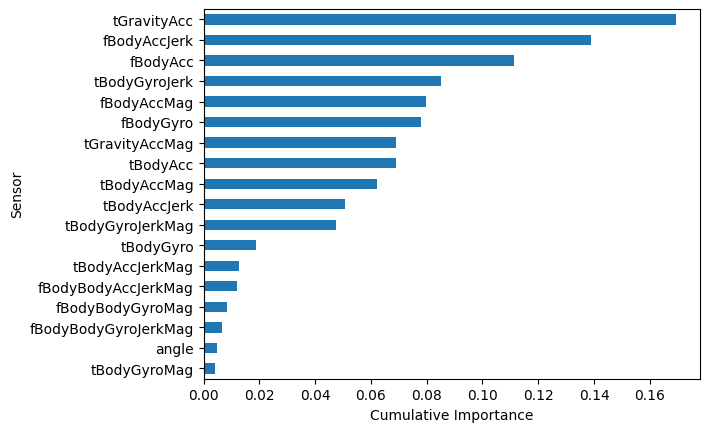

In [ ]:
sensor_importance6 = fi6.groupby('sensor')['importance'].sum().sort_values()
sensor_importance6.plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor")
plt.show()

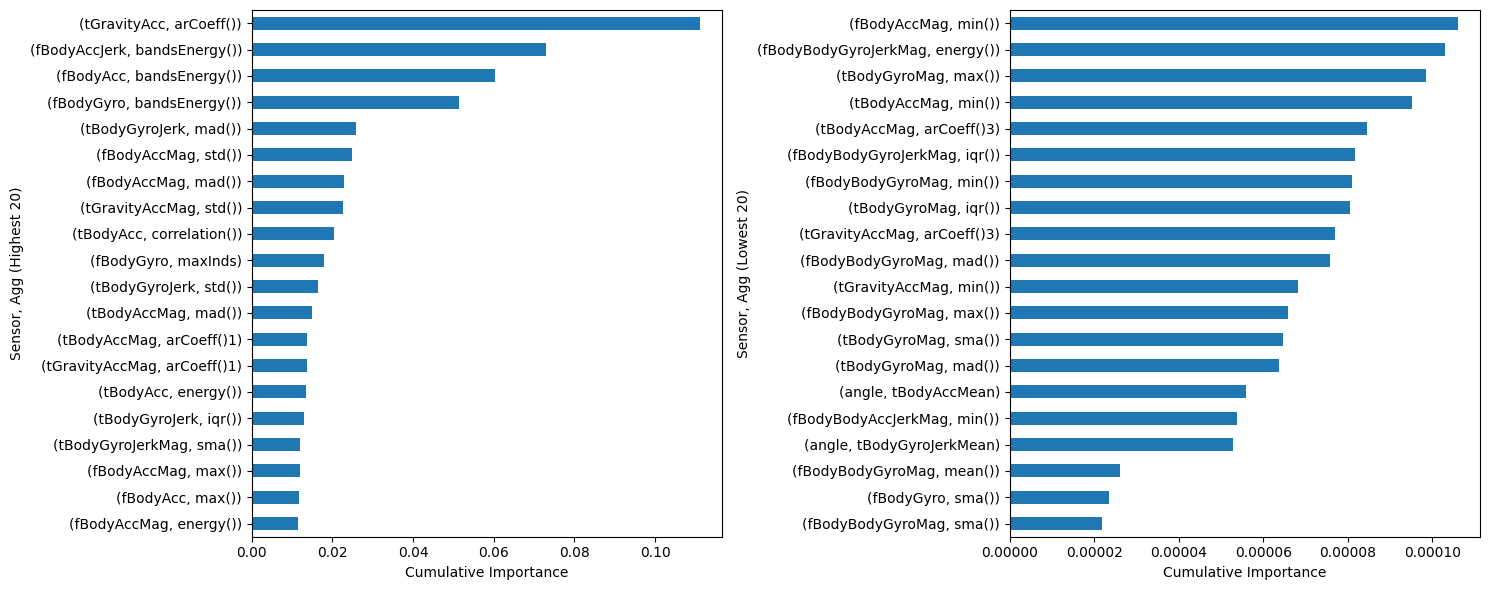

In [ ]:
sensor_agg_importance6 = fi6.groupby(['sensor', 'agg'])['importance'].sum().sort_values()

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sensor_agg_importance6.tail(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Highest 20)")

plt.subplot(1,2,2)
sensor_agg_importance6.head(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Lowest 20)")
plt.tight_layout()
plt.show()

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
def convert_activity_to_walking_up(activity):
    if activity == 'WALKING_UPSTAIRS':
        return 1
    else:
        return 0
y = data['Activity'].apply(convert_activity_to_walking_up)
y.value_counts()

0    5023
1     858
Name: Activity, dtype: int64

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(4704, 562) (1177, 562) (4704,) (1177,)


In [ ]:
RF_model7 = RandomForestClassifier(random_state=42)
RF_model7.fit(x_train, y_train)
print(RF_model7.score(x_valid, y_valid))

0.9932030586236194


,feature_name,feature_importance
0,tGravityAcc-min()-Y,0.033007
1,"tGravityAcc-arCoeff()-Z,2",0.028815
2,"fBodyAcc-bandsEnergy()-1,8.2",0.027944
3,"angle(Y,gravityMean)",0.027714
4,"tGravityAcc-arCoeff()-Z,1",0.027039


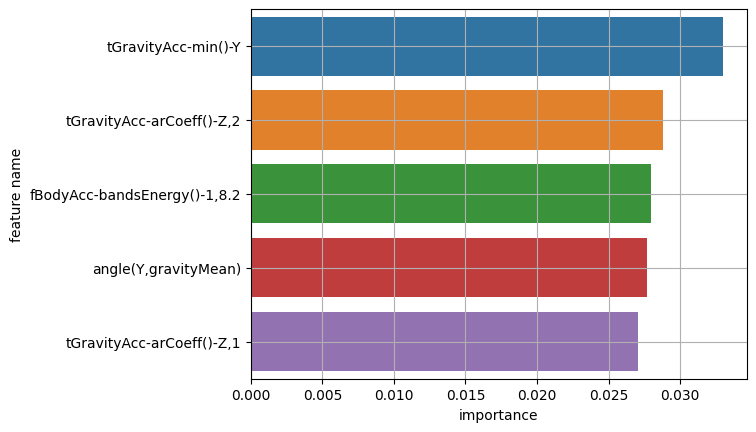

In [ ]:
plot_feature_importance(RF_model7.feature_importances_, x.columns, topn=5)

In [ ]:
importances7 = pd.DataFrame({
    'feature_name': x.columns,
    'importance': RF_model7.feature_importances_
})
fi7 = pd.merge(features, importances7, on='feature_name')
fi7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sensor        561 non-null    object 
 1   agg           561 non-null    object 
 2   axis          436 non-null    object 
 3   feature_name  561 non-null    object 
 4   importance    561 non-null    float64
dtypes: float64(1), object(4)
memory usage: 26.3+ KB


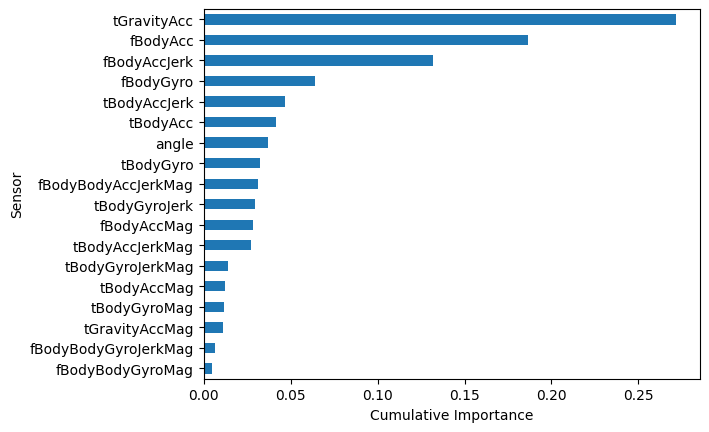

In [ ]:
sensor_importance7 = fi7.groupby('sensor')['importance'].sum().sort_values()
sensor_importance7.plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor")
plt.show()

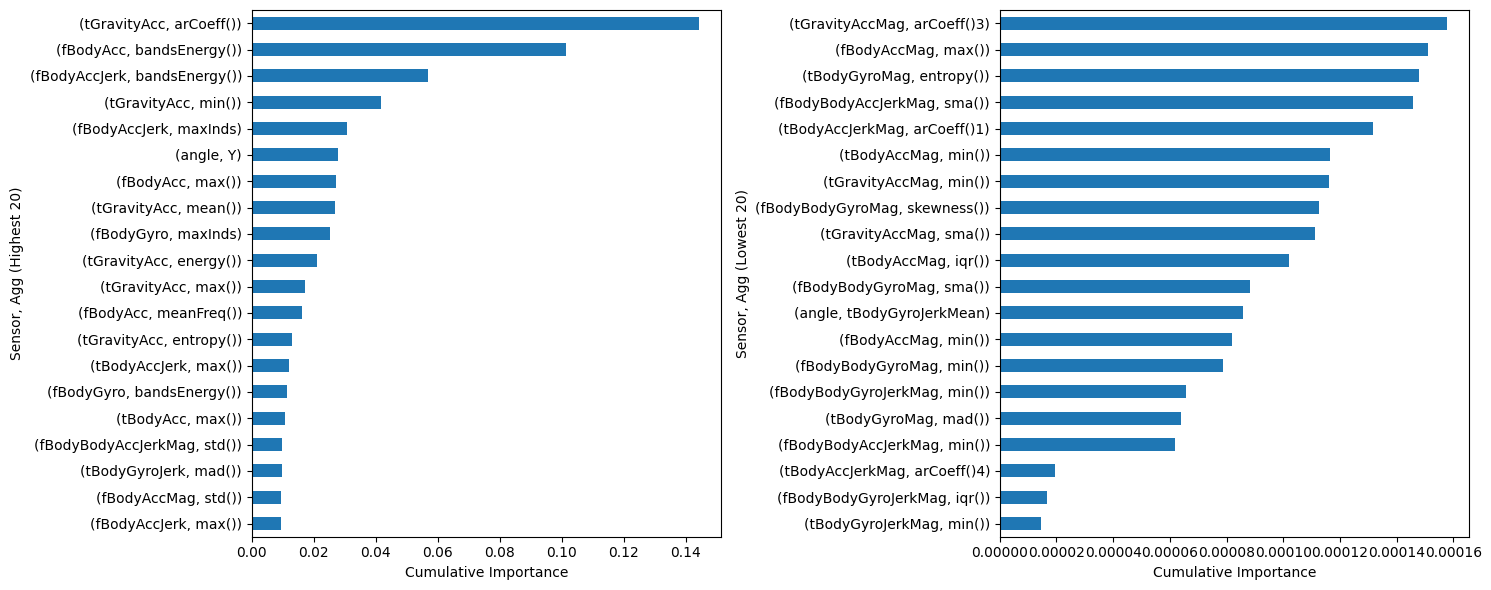

In [ ]:
sensor_agg_importance7 = fi7.groupby(['sensor', 'agg'])['importance'].sum().sort_values()

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sensor_agg_importance7.tail(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Highest 20)")

plt.subplot(1,2,2)
sensor_agg_importance7.head(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Lowest 20)")
plt.tight_layout()
plt.show()

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
def convert_activity_to_walking_down(activity):
    if activity == 'WALKING_DOWNSTAIRS':
        return 1
    else:
        return 0
y = data['Activity'].apply(convert_activity_to_walking_down)
y.value_counts()

0    5090
1     791
Name: Activity, dtype: int64

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(4704, 562) (1177, 562) (4704,) (1177,)


In [ ]:
RF_model8 = RandomForestClassifier(random_state=42)
RF_model8.fit(x_train, y_train)
print(RF_model8.score(x_valid, y_valid))

0.989804587935429


,feature_name,feature_importance
0,tGravityAccMag-std(),0.058157
1,fBodyAccMag-sma(),0.044166
2,tBodyAcc-max()-X,0.036825
3,tBodyAccMag-std(),0.034403
4,"fBodyAcc-bandsEnergy()-1,16",0.029291


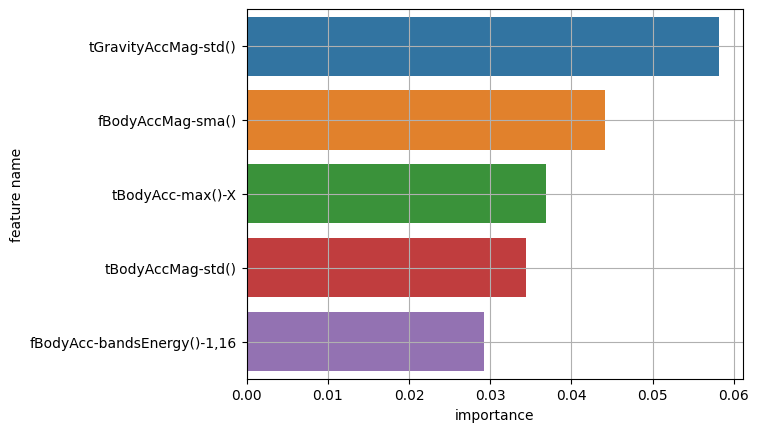

In [ ]:
plot_feature_importance(RF_model8.feature_importances_, x.columns, topn=5)

In [ ]:
importances8 = pd.DataFrame({
    'feature_name': x.columns,
    'importance': RF_model8.feature_importances_
})
fi8 = pd.merge(features, importances8, on='feature_name')
fi8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sensor        561 non-null    object 
 1   agg           561 non-null    object 
 2   axis          436 non-null    object 
 3   feature_name  561 non-null    object 
 4   importance    561 non-null    float64
dtypes: float64(1), object(4)
memory usage: 26.3+ KB


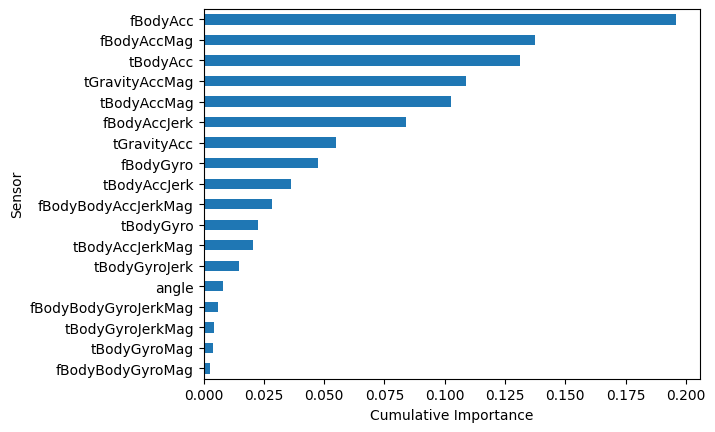

In [ ]:
sensor_importance8 = fi8.groupby('sensor')['importance'].sum().sort_values()
sensor_importance8.plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor")
plt.show()

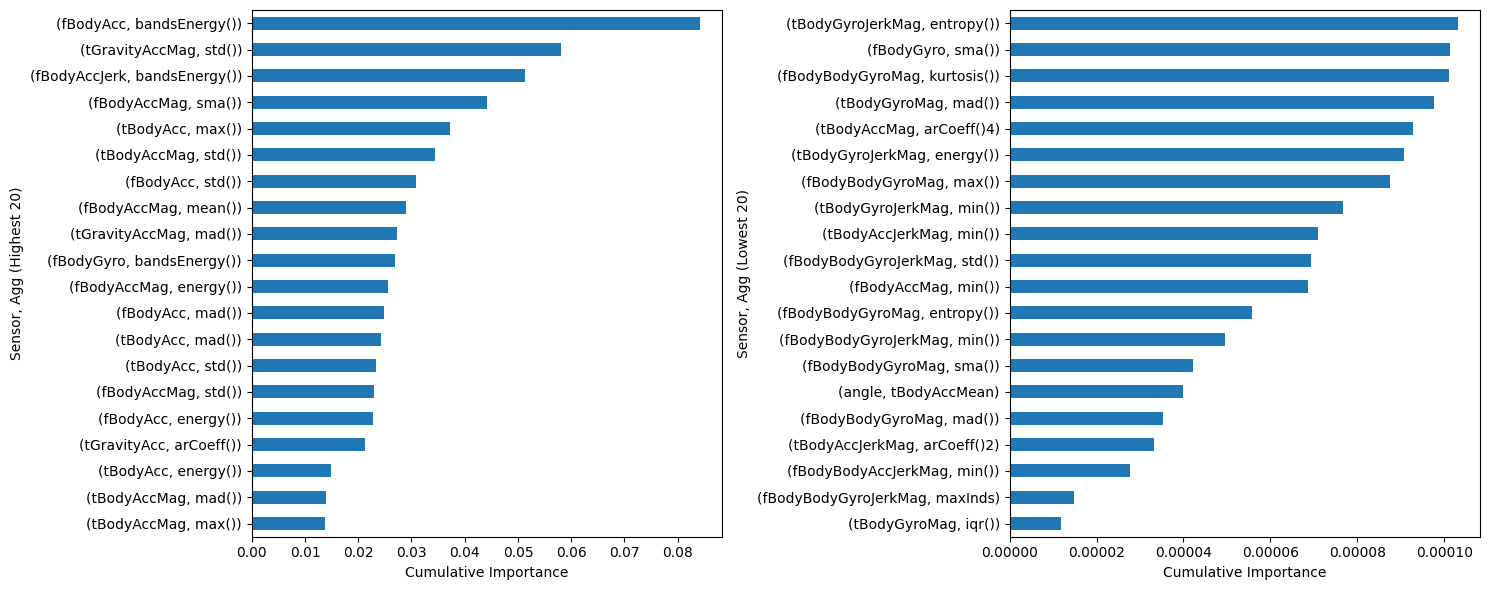

In [ ]:
sensor_agg_importance8 = fi8.groupby(['sensor', 'agg'])['importance'].sum().sort_values()

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sensor_agg_importance8.tail(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Highest 20)")

plt.subplot(1,2,2)
sensor_agg_importance8.head(20).plot(kind='barh')
plt.xlabel("Cumulative Importance")
plt.ylabel("Sensor, Agg (Lowest 20)")
plt.tight_layout()
plt.show()

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [ ]:
features_all = features.copy()
importances.rename(columns={'importance': 'importance1'}, inplace=True)
features_all = pd.merge(features_all, importances, on='feature_name')

importances2.rename(columns={'importance': 'importance2'}, inplace=True)
features_all = pd.merge(features_all, importances2, on='feature_name')

importances3.rename(columns={'importance': 'importance3'}, inplace=True)
features_all = pd.merge(features_all, importances3, on='feature_name')

importances4.rename(columns={'importance': 'importance4'}, inplace=True)
features_all = pd.merge(features_all, importances4, on='feature_name')

importances5.rename(columns={'importance': 'importance5'}, inplace=True)
features_all = pd.merge(features_all, importances5, on='feature_name')

importances6.rename(columns={'importance': 'importance6'}, inplace=True)
features_all = pd.merge(features_all, importances6, on='feature_name')

importances7.rename(columns={'importance': 'importance7'}, inplace=True)
features_all = pd.merge(features_all, importances7, on='feature_name')

importances8.rename(columns={'importance': 'importance8'}, inplace=True)
features_all = pd.merge(features_all, importances8, on='feature_name')

features_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sensor        561 non-null    object 
 1   agg           561 non-null    object 
 2   axis          436 non-null    object 
 3   feature_name  561 non-null    object 
 4   importance1   561 non-null    float64
 5   importance2   561 non-null    float64
 6   importance3   561 non-null    float64
 7   importance4   561 non-null    float64
 8   importance5   561 non-null    float64
 9   importance6   561 non-null    float64
 10  importance7   561 non-null    float64
 11  importance8   561 non-null    float64
dtypes: float64(8), object(4)
memory usage: 57.0+ KB


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
joblib.dump(features_all, os.path.join(FOLDER_PATH, 'features_all.pkl'))

['/content/drive/MyDrive/Colab Notebooks/미니프로젝트 5차/features_all.pkl']